## **<font color="green">Forecasting con Redes LSTM</font>**

### Dataset

Usaremos el [weather dataset](https://www.bgc-jena.mpg.de/wetter/weather_data.html), un set de datos del Instituto Planck para Biogeoquímica que contiene el registro histórico de diferentes variables climáticas.

En particular este dataset:

    Contiene 14 diferentes features (temperatura del aire, presión atmosférica, humedad, etc.)
    Cada variable ha sido recolectada con una periodicidad de 1 hora comenzando en el año 2009.

En este caso usaremos datos recolectados entre 2009 y 2015.

### El problema a resolver

lo que buscamos es desarrollar modelos predictivos basados en Redes LSTM usando los enfoques para predecir la temperatura:

    Univariado + single-step
    Univariado + multi-step
    Multivariado + single-step
    Multivariado + multi-step

En cualquiera de estos casos es garantizar la integridad de nuestro dataset.

### Lectura del dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
path = "../0.data/time_series/weather_dataset.csv"
df = pd.read_csv(path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,31/12/2015 23:50,999.13,0.10,273.32,-0.32,97.0,6.15,5.97,0.18,3.72,...,0.79,1.40,194.8,0,0,0.0,0.0,0.0,11.51,426.0
1,31/12/2015 23:40,999.14,0.08,273.31,-0.35,96.9,6.15,5.95,0.19,3.72,...,0.74,1.40,182.3,0,0,0.0,0.0,0.0,11.51,427.0
2,31/12/2015 23:30,999.20,0.16,273.39,-0.25,97.0,6.18,6.00,0.19,3.74,...,0.99,1.72,189.2,0,0,0.0,0.0,0.0,11.51,426.5
3,31/12/2015 23:20,999.07,0.20,273.44,-0.19,97.2,6.20,6.03,0.17,3.76,...,1.36,2.32,199.6,0,0,0.0,0.0,0.0,11.52,425.0
4,31/12/2015 23:10,999.02,0.26,273.49,-0.15,97.1,6.22,6.04,0.18,3.77,...,1.22,1.56,199.3,0,0,0.0,0.0,0.0,11.56,425.4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368291 entries, 0 to 368290
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date Time             368291 non-null  object 
 1   p (mbar)              368291 non-null  float64
 2   T (degC)              368291 non-null  float64
 3   Tpot (K)              368291 non-null  float64
 4   Tdew (degC)           368291 non-null  float64
 5   rh (%)                368291 non-null  float64
 6   VPmax (mbar)          368291 non-null  float64
 7   VPact (mbar)          368291 non-null  float64
 8   VPdef (mbar)          368291 non-null  float64
 9   sh (g/kg)             368291 non-null  float64
 10  H2OC (mmol/mol)       368291 non-null  float64
 11  rho (g/m**3)          368291 non-null  float64
 12  wv (m/s)              368291 non-null  float64
 13  max. wv (m/s)         368291 non-null  float64
 14  wd (deg)              368291 non-null  float64
 15  

### Procesamiento inicial de datos

In [8]:
# Convertir la columna "Date Time" al formato datetime
df['datetime'] = pd.to_datetime(df["Date Time"], format='%d/%m/%Y %H:%M')

# Ahora reemplazar los indices del dataframe por la nueva columna 'datetime'
df = df.set_index('datetime')

# Ordenar el dataset de forma ascendente en base indice de fechas(cronológica)
df.sort_index(inplace=True)

# Eliminar la anterior columna 'Date Time'
df = df.drop(columns=['Date Time'])

df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,...,1.03,1.75,152.3,0,0,0.0,0.0,0.0,7.20,434.4
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,...,0.72,1.50,136.1,0,0,0.0,0.0,0.0,7.15,436.2
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,...,0.19,0.63,171.6,0,0,0.0,0.0,0.0,7.09,435.1
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,...,0.34,0.50,198.0,0,0,0.0,0.0,0.0,7.38,427.1
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,...,0.32,0.63,214.3,0,0,0.0,0.0,0.0,8.28,415.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 23:10:00,999.02,0.26,273.49,-0.15,97.1,6.22,6.04,0.18,3.77,6.05,...,1.22,1.56,199.3,0,0,0.0,0.0,0.0,11.56,425.4
2015-12-31 23:20:00,999.07,0.20,273.44,-0.19,97.2,6.20,6.03,0.17,3.76,6.03,...,1.36,2.32,199.6,0,0,0.0,0.0,0.0,11.52,425.0
2015-12-31 23:30:00,999.20,0.16,273.39,-0.25,97.0,6.18,6.00,0.19,3.74,6.00,...,0.99,1.72,189.2,0,0,0.0,0.0,0.0,11.51,426.5


## Análisis exploratorio

### Paso 1: comprender las variables del set de datos

Se encontró un total de 14 variables:

    * p (mbar): presión del aire en milibars
    * T (degC): temperatura del aire en °C
    * Tpot (K): temperatura potencial
    * Tdew (degC): temperatura de punto de rocío (a la cual el vapor de agua se condensa)
    * rh (%): humedad relativa
    * VPmax (mbar): presión de vapor de agua de saturación
    * VPact (mbar): presión de vapor de agua real
    * VPdef (mbar): déficit de presión de vapor de agua
    * sh (g/kg): humedad específica
    * H2OC (mmol/mol): nivel de concentración del vapor de agua
    * rho (g/m**3): densidad del aire
    * wv (m/s): velocidad del viento
    * max. wv (m/s): velocidad del viento máxima
    * wd (deg): dirección del viento

Además, al momento de implementar los modelos predictivos se tendrá dos tipos de variables:

    * La variable a predecir: 
        Es la variable que queremos pronosticar y que será la salida de cada uno de los modelos LSTM. En este caso esta variable a predecir es la temperatura (columna T (degC) de nuestro dataset).

    * Las variables predictoras (o covariables): 
        Será(n) la(s) variable(s) de entrada a los diferentes modelos LSTM y a partir de las cuáles dichos modelos podrán realizar la predicción. 
    
    En este caso las covariables son todas las columnas de nuestro dataset (incluyendo la misma temperatura a predecir - T (degC) - así como posiblemente la variable tiempo - índice datetime -).


### Paso 2: visualizar el set de datos

In [9]:
import mplcyberpunk

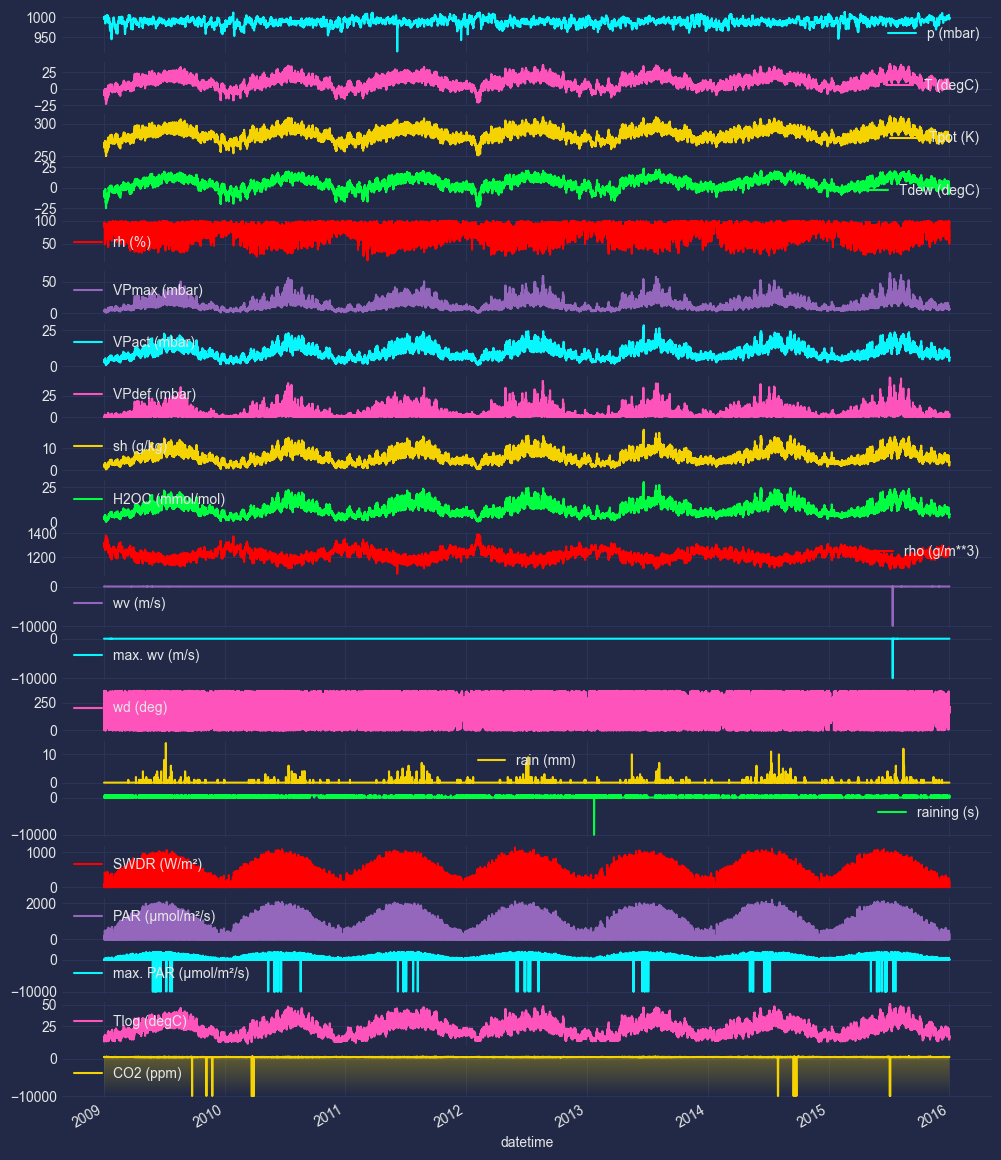

In [10]:
# Columnas del dataset
cols = df.columns # columnas a graficar

# Dibujar la totalidad de registros
# N = 24*30*12 # Dibujar 1 año continuo con una periodicidad de 1hr
N = df.shape[0]       # Número de registros o variables a graficar
plots = df[cols][0:N] # Series de tiempo individuales -> variables y rango a dibujar
plots.index = df.index[0:N] # Variable tiempo -> indice de nuestras variables

plt.style.use("cyberpunk")
_ = plots.plot(subplots=True, figsize=(12,16))

mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.3)
plt.show()

### Paso 3: Análisis de datos faltantes

In [11]:
df.isna().sum()

p (mbar)                0
T (degC)                0
Tpot (K)                0
Tdew (degC)             0
rh (%)                  0
VPmax (mbar)            0
VPact (mbar)            0
VPdef (mbar)            0
sh (g/kg)               0
H2OC (mmol/mol)         0
rho (g/m**3)            0
wv (m/s)                0
max. wv (m/s)           0
wd (deg)                0
rain (mm)               0
raining (s)             0
SWDR (W/m²)             0
PAR (µmol/m²/s)         0
max. PAR (µmol/m²/s)    0
Tlog (degC)             0
CO2 (ppm)               0
dtype: int64

### Paso 4: Análisis de la periodicidad del dataset

In [12]:
# Verificar si la periodicidad de las muestras es exactamente 1hr(3600s)

# Calcular la diferencia en segundos entre cada par de datos consecutivos
df_time_diffs = df.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

600.0      367959
0.0           327
1200.0          2
1800.0          1
57600.0         1
Name: datetime, dtype: int64


Del total de registros:
- 367959 tienen una diferencia de 600s (10min)
- 327 tienen una diferencia de 0s
- 2 tienen una diferencia de 1200s(20min)
- 1 tiene una diferencia de 57600s(16hrs)

Llevar a cabo un procesamiento adicional para corregir este comportamiento y que tengan una diferencia de 3600s(1hr)
* Verificar que entre muestras consecutivas se tenga una periodicidad de 1 hora
* Calculando la diferencia de tiempo transcurrido entre el un registro R1 y el siguiente R2

## Paso 5: Preprocesamiento

### 5.1. Manejo de datos faltantes

Suponer que tenemos pocos datos faltantes en las columnas VPmax, H2OC y rho

* Dado que el nro de datos faltantes es pequeño, podemos usar una simple interpolación para completarlos.
* En python interpolate(method='linear')

In [ ]:
columns = ['VPmax (mbar)', 'H2OC (mmol/mol)', 'rho (g/m**3)']

for column in columns:
    df[column] = df[column].interpolate(method='linear')

* Verificar si se realizo la interpolacion correctamente para los datos faltantes

In [13]:
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna p (mbar): 0
	Columna T (degC): 0
	Columna Tpot (K): 0
	Columna Tdew (degC): 0
	Columna rh (%): 0
	Columna VPmax (mbar): 0
	Columna VPact (mbar): 0
	Columna VPdef (mbar): 0
	Columna sh (g/kg): 0
	Columna H2OC (mmol/mol): 0
	Columna rho (g/m**3): 0
	Columna wv (m/s): 0
	Columna max. wv (m/s): 0
	Columna wd (deg): 0
	Columna rain (mm): 0
	Columna raining (s): 0
	Columna SWDR (W/m²): 0
	Columna PAR (µmol/m²/s): 0
	Columna max. PAR (µmol/m²/s): 0
	Columna Tlog (degC): 0
	Columna CO2 (ppm): 0


## Paso 2: Ajuste de periodicidad

* Garantizar que entre cada registro haya 1hora de dif(3600s)

In [14]:
# Primero para los registros ue tienen diferencia de 0 segundos
# Eliminamos datos duplicados
df.drop_duplicates(keep='first', inplace=True, ignore_index=False)
# verificar que se haya realizado la acción
df_time_diffs = df.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

600.0      367959
1200.0          2
1800.0          1
57600.0         1
Name: datetime, dtype: int64


Para corregir estos comportamientos podemos usar el método asfreq de Pandas, que nos permite re-interpolar el dataset con la periodicidad requerida de 1 hora.

Durante esta reinterpolación estaremos insertando nuevos registros, así que usaremos la opción bfill para que el nuevo registro insertado tenga un valor igual al registro inmediatamente anterior

In [15]:
df2 = df.asfreq(freq='H', method='bfill')

Finalmente, verifiquemos que la periodicidad del DataFrame resultante (df2) es exactamente 3.600 s en todos los pares de registros consecutivos:

In [16]:
df_time_diffs = df2.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

3600.0    61343
Name: datetime, dtype: int64


In [17]:
df.isna().sum()

p (mbar)                0
T (degC)                0
Tpot (K)                0
Tdew (degC)             0
rh (%)                  0
VPmax (mbar)            0
VPact (mbar)            0
VPdef (mbar)            0
sh (g/kg)               0
H2OC (mmol/mol)         0
rho (g/m**3)            0
wv (m/s)                0
max. wv (m/s)           0
wd (deg)                0
rain (mm)               0
raining (s)             0
SWDR (W/m²)             0
PAR (µmol/m²/s)         0
max. PAR (µmol/m²/s)    0
Tlog (degC)             0
CO2 (ppm)               0
dtype: int64

* Verificamos las columnas originales y modificadas, esto con la finalidad de constatar los valores promedio de ambas

In [20]:
for column in df:
    print(f'Promedios original/modificado: {df[column].mean():.2f}/{df2[column].mean():.2f} -> variable <{column}>')

Promedios original/modificado: 989.10/989.10 -> variable <p (mbar)>
Promedios original/modificado: 9.36/9.36 -> variable <T (degC)>
Promedios original/modificado: 283.42/283.42 -> variable <Tpot (K)>
Promedios original/modificado: 4.88/4.88 -> variable <Tdew (degC)>
Promedios original/modificado: 76.06/76.07 -> variable <rh (%)>
Promedios original/modificado: 13.50/13.50 -> variable <VPmax (mbar)>
Promedios original/modificado: 9.50/9.50 -> variable <VPact (mbar)>
Promedios original/modificado: 4.01/4.00 -> variable <VPdef (mbar)>
Promedios original/modificado: 6.00/6.00 -> variable <sh (g/kg)>
Promedios original/modificado: 9.60/9.60 -> variable <H2OC (mmol/mol)>
Promedios original/modificado: 1216.31/1216.32 -> variable <rho (g/m**3)>
Promedios original/modificado: 1.65/1.65 -> variable <wv (m/s)>
Promedios original/modificado: 3.01/2.89 -> variable <max. wv (m/s)>
Promedios original/modificado: 174.44/174.56 -> variable <wd (deg)>
Promedios original/modificado: 0.00/0.00 -> variable

In [21]:
df2.to_csv('../0.data/time_series/weather_preprocessed.csv')

## FORECASTING CON REDES LSTM - MODELO UNIVARIADO - UNISTEP

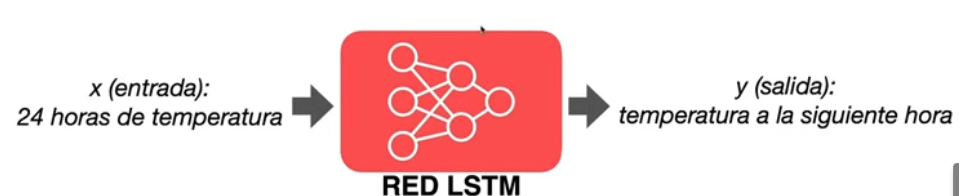

* Predeciremos con una variable solo un instante de tiempo

* Se ingresará un registro de 24 horas continuas de temperatura
* y predecirá la temperatura de la hora nro 25

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../0.data/time_series/weather_preprocessed.csv")
df

,datetime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,...,1.03,1.75,152.3,0,0,0.0,0.0,0.0,7.20,434.4
1,2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,...,0.18,0.63,166.5,0,0,0.0,0.0,0.0,9.27,422.0
2,2009-01-01 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,...,0.16,0.50,158.3,0,0,0.0,0.0,0.0,8.00,429.7
3,2009-01-01 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,...,0.07,0.25,129.3,0,0,0.0,0.0,0.0,9.31,424.5
4,2009-01-01 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,...,0.10,0.38,203.9,0,0,0.0,0.0,0.0,7.79,429.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61339,2015-12-31 19:10:00,998.56,1.01,274.28,0.49,96.3,6.57,6.33,0.24,3.95,...,1.75,3.04,194.2,0,0,0.0,0.0,0.0,12.81,424.8
61340,2015-12-31 20:10:00,998.99,1.07,274.31,0.61,96.7,6.60,6.38,0.22,3.98,...,1.20,1.84,208.8,0,0,0.0,0.0,0.0,12.76,424.7
61341,2015-12-31 21:10:00,998.90,0.83,274.07,0.38,96.8,6.49,6.28,0.21,3.92,...,1.92,2.56,205.1,0,0,0.0,0.0,0.0,12.87,426.3
61342,2015-12-31 22:10:00,998.76,0.52,273.78,0.11,97.1,6.34,6.16,0.18,3.84,...,1.60,2.78,215.3,0,0,0.0,0.0,0.0,12.11,425.4


### Partición del set de datos -> entrenamiento, validación y prueba

In [10]:
def train_validation_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [11]:
data = df['T (degC)']
data_train, data_val, data_test = train_validation_test_split(data)

In [12]:
# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {data_train.shape}')
print(f'Tamaño set de validación: {data_val.shape}')
print(f'Tamaño set de prueba: {data_test.shape}')

Tamaño set de entrenamiento: (49075,)
Tamaño set de validación: (6134,)
Tamaño set de prueba: (6135,)


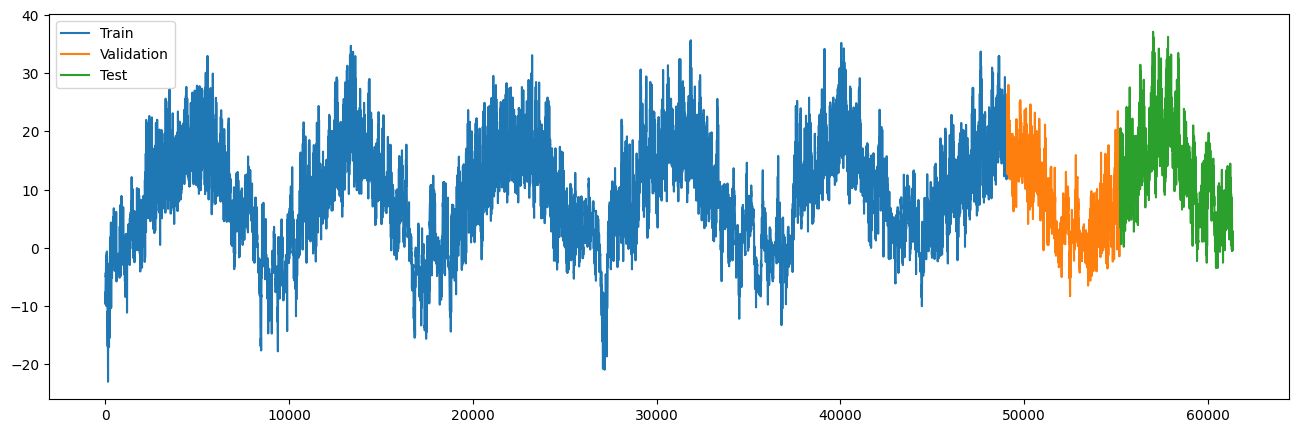

In [13]:
# Graficar para ver la distribucion de las particiones de forma consecutiva
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(data_train, label='Train')
ax.plot(data_val, label='Validation')
ax.plot(data_test, label='Test')
plt.legend();

### Generación del dataset supervisado(entrada y salida del modelo)

* Partiremos la secuencia de datos en pequeños bloques o lotes(batches) para presentarselo al modelo durante el entrenamiento y la validación

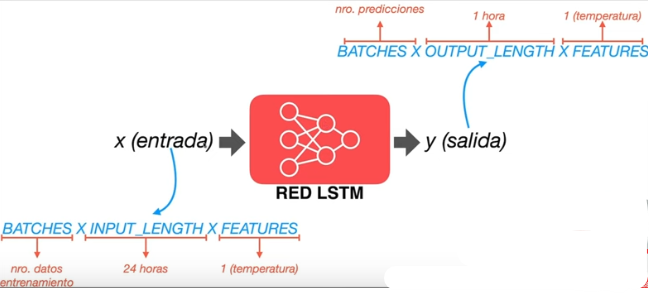
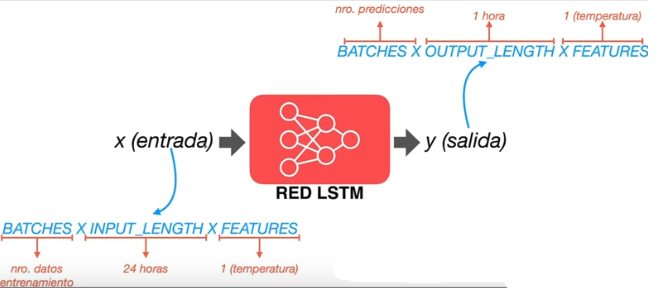
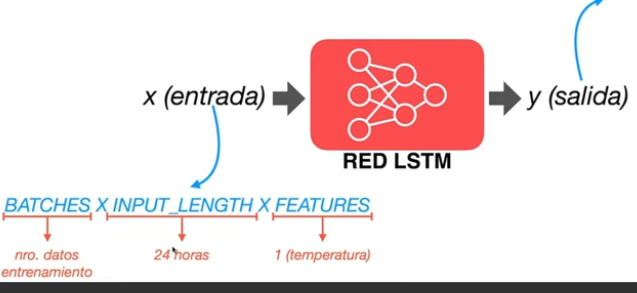

* Un arreglo de 24hrs x 1(feature) correspondiente a la entrada
* Un arreglo de 1hr x 1(feature) correspondiente a la hora 25(a predecir)

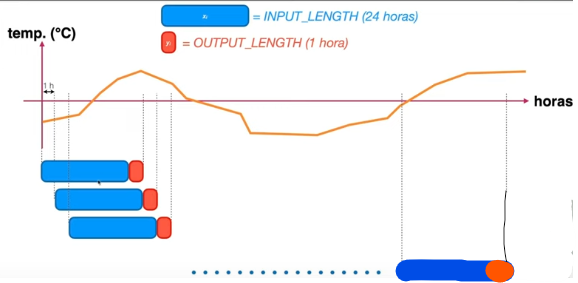
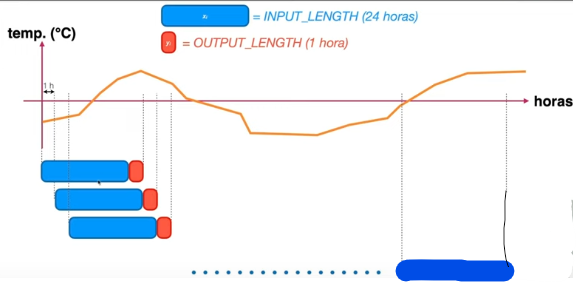

Esto implica generar los arreglos X (entrada al modelo) y Y (salida del modelo) de forma tal que al crear y entrenar la Red LSTM esta aprenda a predecir la temperatura de forma adecuada.

En este caso decimos que debemos crear el dataset supervisado puesto que debemos presentar al modelo tanto la entrada (X) como la salida (Y) y cuando entrenamos un modelo presentando tanto las entradas como las salidas estamos usando precisamente un enfoque de aprendizaje supervisado.

Según lo mencionado anteriormente, para este modelo predictivo usaremos el enfoque univariado-unistep, y especificamente:

    Ingresaremos al modelo registros continuos de 24 horas para la variable temperatura y
    El modelo deberá aprender a predecir una hora a futuro


Teniendo en cuenta lo especificado en la documentación de las Redes LSTM en TensorFlow/Keras, debemos estructurar nuestros sets de la siguiente manera:

    Entrada (X): arreglo de tamaño batches x input_length x features
    Salida (Y): arreglo de tamaño batches x output_length x features

donde:

    batches es el número total de datos de entrada y de salida. Por ejemplo, el set de entrenamiento tiene un total de 40.179 datos pero estos deberán ser divididos en bloques consecutivos de 25 registros (24 horas de entrada + 1 hora de salida). Cada uno de estos bloques será un dato de entrenamiento y los batches serán simplemente el número total de bloques de 25 horas.
    input_length es el número de registros consecutivos que usaremos a la entrada del modelo. En nuestro caso este valor es igual a 24 (horas) y esto se convertirá en un hiperparámetro del modelo que se podrá modificar y que impactará el desempeño del modelo obtenido.
    features es simplemente el número de variables de entrada o de salida que usaremos. Como estamos usando un enfoque univariado y a la salida haremos la predicción únicamente de la variable temperatura, en ambos casos tendremos features = 1
    output_length es el número de horas a futuro que queremos predecir con el modelo. Por tratarse de un enfoque unistep, en este caso tendremos output_length = 1

Teniendo en cuenta lo anterior, podemos concluir que cada subset (entrenamiento, validación y prueba) deberá ser pre-procesado para obtener los arreglos X (entradas) y Y (salidas) los cuales tendrán estos tamaños:

    X: batches x 24 x 1
    Y: batches x 1 x 1


In [14]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [15]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 24 horas consecutivas a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 hora a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
X_train, y_train = crear_dataset_supervisado(data_train.values, INPUT_LENGTH, OUTPUT_LENGTH)
X_val, y_val = crear_dataset_supervisado(data_val.values, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = crear_dataset_supervisado(data_test.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [16]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Set de validación - X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'Set de prueba - X_test: {X_test.shape}, y_test: {y_test.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - X_train: (49050, 24, 1), y_train: (49050, 1, 1)
Set de validación - X_val: (6109, 24, 1), y_val: (6109, 1, 1)
Set de prueba - X_test: (6110, 24, 1), y_test: (6110, 1, 1)


## Escalamiento

Existen varias estrategias de escalamiento (como la normalización o la estandarización), en este tutorial usaremos una estrategia simple: escalaremos los valores al rango de -1 a 1.

Así por ejemplo, si las temperaturas mínima y máxima están en el rango de -20 °C a 35 °C, al hacer el escalamiento estos valores estarán en el rango de -1 a 1.

In [33]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2] # Nro de features

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(data_input['x_tr'][:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(data_input['x_vl'][:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(data_input['x_ts'][:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(data_input['y_tr'][:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(data_input['y_vl'][:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(data_input['y_ts'][:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [39]:
# diccionario con los datos
data_in = {
    'x_tr': X_train, 'y_tr': y_train,
    'x_vl': X_val, 'y_vl': y_val,
    'x_ts': X_test, 'y_ts': y_test
}

# aplicar escalamiento a los datos entre -1 y 1
data_s, scaler = escalar_dataset(data_in)

# extraer los subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

print(f'Max SIN ESCALAMIENTO x_train/x_val/x_test : {X_train.max()} / {X_val.max()} / {X_test.max()}')
print(f'Max CON ESCALAMIENTO x_train/x_val/x_test : {x_tr_s.max()} / {x_vl_s.max()} / {x_ts_s.max()}')

print(f'\nMin SIN ESCALAMIENTO x_train/x_val/x_test : {X_train.min()} / {X_val.min()} / {X_test.min()}')
print(f'Min CON ESCALAMIENTO x_train/x_val/x_test : {x_tr_s.min()} / {x_vl_s.min()} / {x_ts_s.min()}')


print(f'\nMax SIN ESCALAMIENTO y_train/y_val/y_test : {y_train.max()} / {y_val.max()} / {y_test.max()}')
print(f'Max CON ESCALAMIENTO y_train/y_val/y_test : {y_tr_s.max()} / {y_vl_s.max()} / {y_ts_s.max()}')

print(f'\nMin SIN ESCALAMIENTO y_train/y_val/y_test : {y_train.min()} / {y_val.min()} / {y_test.min()}')
print(f'Min CON ESCALAMIENTO y_train/y_val/y_test : {y_tr_s.min()} / {y_vl_s.min()} / {y_ts_s.min()}')

Max SIN ESCALAMIENTO x_train/x_val/x_test : 35.68 / 28.01 / 37.13
Max CON ESCALAMIENTO x_train/x_val/x_test : 1.0 / 0.7386266825694326 / 1.0494121656159483

Min SIN ESCALAMIENTO x_train/x_val/x_test : -23.01 / -8.3 / -3.46
Min CON ESCALAMIENTO x_train/x_val/x_test : -1.0 / -0.4987220991651048 / -0.3337876980746294

Max SIN ESCALAMIENTO y_train/y_val/y_test : 35.68 / 28.01 / 37.13
Max CON ESCALAMIENTO y_train/y_val/y_test : 1.0 / 0.7386266825694326 / 1.0494121656159483

Min SIN ESCALAMIENTO y_train/y_val/y_test : -23.01 / -8.3 / -3.46
Min CON ESCALAMIENTO y_train/y_val/y_test : -1.0 / -0.4987220991651048 / -0.3337876980746294


## MODELADO

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

In [41]:
tf.random.set_seed(123)

tf.config.experimental.enable_op_determinism()
N_UNITS = 128
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

In [42]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [43]:
optimizador = RMSprop(learning_rate=5e-5)

modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

In [44]:
EPOCHS = 80
BATCH_SIZE = 256

historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
192/192 - 28s - loss: 0.1847 - val_loss: 0.0990 - 28s/epoch - 146ms/step
Epoch 2/80
192/192 - 12s - loss: 0.1132 - val_loss: 0.0877 - 12s/epoch - 62ms/step
Epoch 3/80
192/192 - 12s - loss: 0.0981 - val_loss: 0.0755 - 12s/epoch - 60ms/step
Epoch 4/80
192/192 - 11s - loss: 0.0795 - val_loss: 0.0607 - 11s/epoch - 56ms/step
Epoch 5/80
192/192 - 12s - loss: 0.0629 - val_loss: 0.0539 - 12s/epoch - 62ms/step
Epoch 6/80
192/192 - 11s - loss: 0.0576 - val_loss: 0.0518 - 11s/epoch - 58ms/step
Epoch 7/80
192/192 - 11s - loss: 0.0544 - val_loss: 0.0491 - 11s/epoch - 58ms/step
Epoch 8/80
192/192 - 11s - loss: 0.0516 - val_loss: 0.0472 - 11s/epoch - 58ms/step
Epoch 9/80
192/192 - 12s - loss: 0.0492 - val_loss: 0.0448 - 12s/epoch - 62ms/step
Epoch 10/80
192/192 - 12s - loss: 0.0472 - val_loss: 0.0435 - 12s/epoch - 61ms/step
Epoch 11/80
192/192 - 12s - loss: 0.0454 - val_loss: 0.0420 - 12s/epoch - 63ms/step
Epoch 12/80
192/192 - 11s - loss: 0.0440 - val_loss: 0.0406 - 11s/epoch - 57ms/step


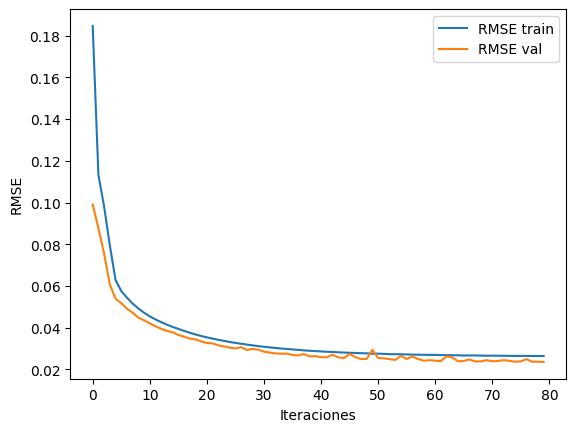

In [49]:
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteraciones')
plt.ylabel('RMSE')
plt.legend();

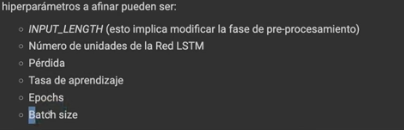

## Desempeño del modelo

In [50]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.024
  RMSE val:	 0.022
  RMSE test:	 0.026


## Predicciones (forecasting) con el modelo entrenado

In [46]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [47]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

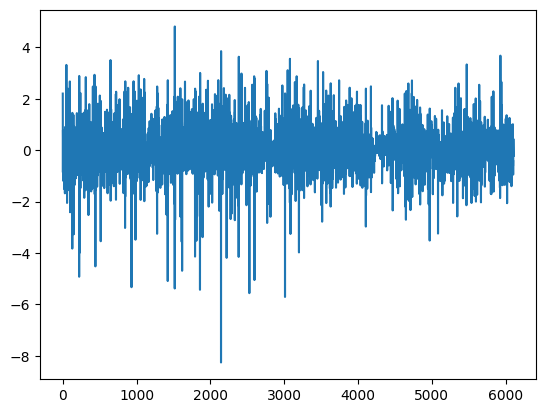

In [48]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_test.flatten()-y_ts_pred
plt.plot(errores);

# 